# Job Board Analysis
## Team 5

- Keegan Ritchie
- Erika Ackley
- Khoa Vo
- Ethan Waple
- Ananda Francis

## Executive summary
This project confronts machine-based hiring barriers with a machine-based solution, informing applicants of what available positions best match their skillset to give them the best shot of being hired for the jobs they want. We collected data from [Indeed](https://www.indeed.com) on current job listings in Boston across several tech-related industries. We [extracted](#extraction) relevant skills from all job descriptions for a given industry and analyzed the [similarities and differences](#comparison) of skills required for specific jobs. Additionally, by inputting resumes, we are able to [recommend](#recommend) the most suitable jobs for a candidate by matching the skills on their resume to the skills from the jobs in our data. To refine the job recommendations, we suggest more advanced skill extraction techniques from the job data collected to ensure proper matching.


## Introduction 

Finding a job during or after graduation is a huge priority to upperclassmen students and is often a difficult and time-consuming task. This is in part because of an increased use in applicant tracking systems (ATS) by employers. In 2021, 75 percent of US employers (and up to 99 percent at Fortune 500 companies) have adopted these increasingly AI-focused application processes, enabling the listing of countless positions while allowing jobseekers to send in countless resumes. While it may be easier than ever to apply for a job, this also means that many fewer resumes are being seen by human eyes, with the ATS software scanning through and filtering out resumes that lack certain keywords and criteria, greatly reducing the number that make it through to be reviewed by the actual employers.

We scraped a list of job recommendations on Indeed, a job listing site, for a variety of jobs in the city of Boston. Our framework is built around tech-related job industries such as data science, analytics, web development, engineering, etc. where we collect job titles and their descriptions using the industry as the search query. 

<img src="https://d341ezm4iqaae0.cloudfront.net/assets/2020/04/06151541/JanusScreenshot-Cropped-747x364.png" width=800px>

## Data Description
For each tech-related industry, web scraping was performed across a range of pages to retrieve as many available jobs posted. From each search query, we obtained the following information:
- Job Title
- Company
- Job URL

Using the job URL for job listings associated with the given search, we were able to extract the job description text for each listing. For each description, keywords were initially filtered out using the Natural Language Toolkit (NLTK) platform and its provided stopwords. While this helped with early analysis and direction, we elected to use just the descriptions themselves for our project methods. 

The search query, job title, company, and descriptions were saved as a csv for each particular industry. Saved CSVs for multiple industries were loaded and combined into one big dataframe, leaving us with a singular data source to work with for our project. 

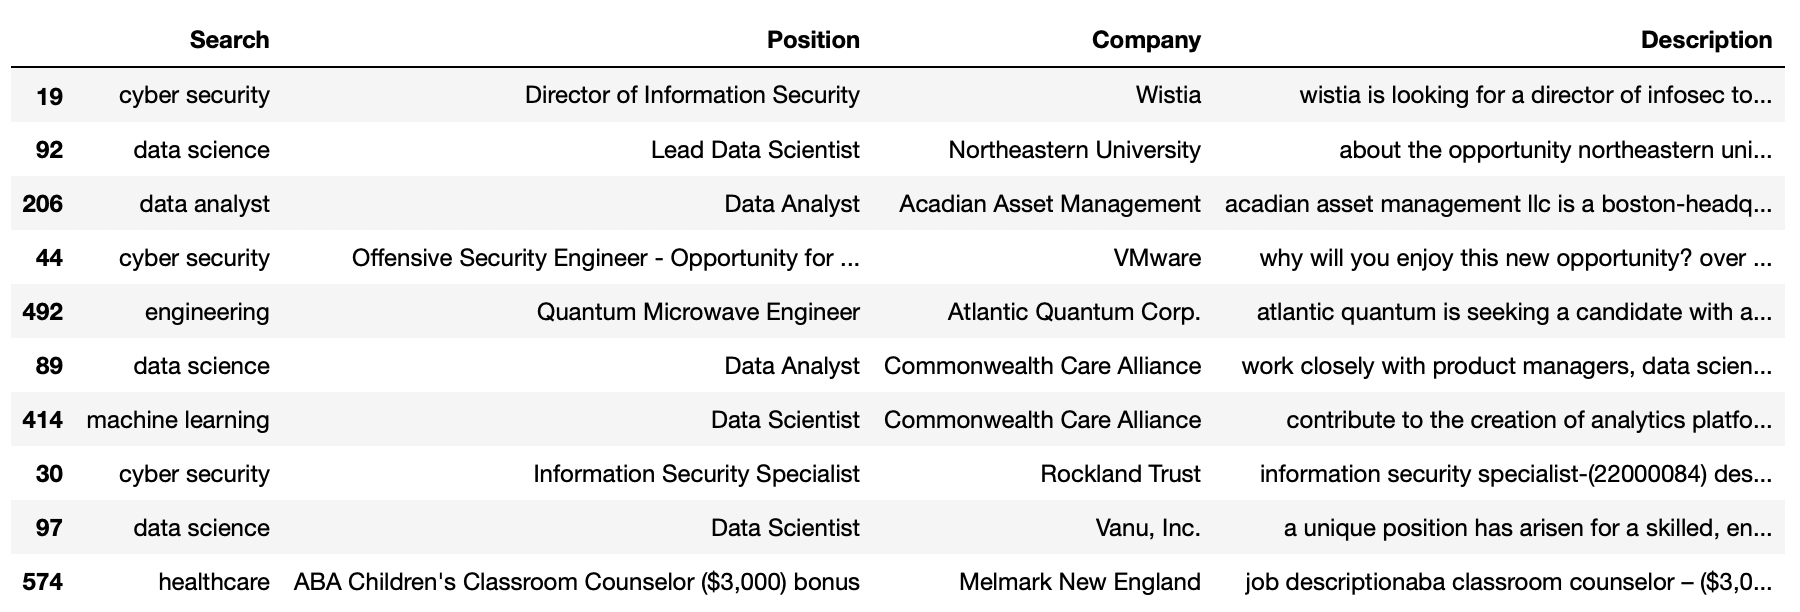

## Pipeline Overview

We accomplished this task with the following functions:

### Webscraping and Formatting Data
- `get_job_url()`
    - build url and return soup object across multiple pages
- `job_type()`
    - returns the job position scraped from Indeed
- `company_name()`
    - returns the company name scraped from Indeed
- `get_href_job()`
    - returns list of urls for link to each specific job
- `get_href_soup()`
    - returns soup object from provided url
- `job_descriptions()`
    - returns the individual job description scraped from Indeed
    
### NLP
- `tokenize()`
    - clean up string using NLP
- `get_top_n_words()`
    - extract most common words from group of job descriptions
    
### Skills Extraction
- `get_all_descriptions()`
    - extract all description strings
- `extract_skills_from_document()`
    - use api to extract the skills from descriptions
- `split_for_request()`
    - split a string into n-character blocks
- `extract_specific_skills`
    - calling api and saving text file of skills
- `add_skills_cols`
    - add columns to df for each skill


### Machine Learning
- `read_resume()`
    - convert resume file to string
- `find_best_jobs()`
    - produce job recommendations based on resume


In [1]:
# import all needed libraries/packages
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import wordcloud as wc
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import numpy as np
from pandas import json_normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
from sklearn.neighbors import NearestNeighbors

In [2]:
def get_job_url(search, location, num):
    ''' gets html content for given search on indeed.com
    
    Args:
        search (str): position or industry
        location (str): desired job location
        page_num (int): page number of job search you want to search
                        our current code only does the first page
    
    Returns:
        soup (soup obj): object containing html content
        of the given search
    '''
    
    # make url
    if num == 1: 
        url = f'https://www.indeed.com/q-{search}-l-{location}-jobs.html'
        
    else:
        url = f'https://www.indeed.com/jobs?q={search}&l={location}&start={10 * num}'
    response = requests.get(url).text
    
    # get response and make soup
    soup = BeautifulSoup(response)
    
    return soup

In [3]:
def job_type(soup):
    ''' creates list of job titles from soup object
    
    Args:
        soup (soup obj): object containing html content
        of the given search
    
    Returns:
        job_lst (list): list of all job titles found in html 
        content
    '''
    
    job_lst = []
    
    # find job titles in html
    for item in soup.find_all('h2', class_ = 'jobTitle'):
        job_lst.append(item.text.replace('new', ''))
    
    return job_lst

In [4]:
def company_name(soup):
    ''' creates list of company names from soup object
    
    Args:
        soup (soup obj): object containing html content
        of the given search
    
    Returns:
        name_lst (list): list of all companies found in html 
        content
    '''
    
    name_lst = []
    
    # find company name in html.
    for item in soup.find_all(class_ = 'heading6 company_location tapItem-gutter companyInfo'):
        name_lst.append(item.span.text)
        
    return name_lst

In [5]:
def get_href_job(soup):
    ''' formats a url for each job in html content
    
    Args:
        soup (soup obj): object containing html content
        of the given search
    
    Returns:
        href_lst (list): list of all of urls for each job
        specific listing from html content
    '''
    
    # find href to own page in html
    
    job_id_lst = []
    href_lst = []
    job = soup.find(id = 'mosaic-provider-jobcards')
    
    # find the specific job ids (each have own class/id)
    job_ids = job.find_all('a', id=True)
    
    # make list of the job ids
    for i in range(0, len(job_ids)):
        job_id_lst.append(job_ids[i]['id'])
    
    # get the href from each specific job
    for val in job_id_lst:
        spec_job = job.find(id = val)
        spec_job.find('a', href=True)
        
        # add indeed.com to link
        href_lst.append('http://indeed.com' + spec_job['href'])
   
    return href_lst

In [6]:
def href_soup(url):
    '''gets text for a given url
    
    Args:
        url(str): url for a specific webpage
    
    Returns:
        soup (soup obj): html text content of given url
    '''
    response = requests.get(url).text
    
    # get response and make soup
    soup = BeautifulSoup(response)
    return soup

In [7]:
def job_descriptions(hrefs):
    '''  creates list of job description text
    
    Args:
        hrefs (list): list of urls containing job descriptions
        on their webpage
    
    Returns:
        descriptions (list): list of all job descriptions found 
        for each url given
    '''
    descriptions = []
    
    # loop through each href, get soup for it
    for url in hrefs:
        new_soup = href_soup(url)
        descriptions.append(new_soup.find(id = 'jobDescriptionText').text)
    
    return descriptions

In [8]:
def make_csv(job_fields, run = False):
    ''' calls webscraping functions and creates csv
    
    Args:
        job_fields (list): list of job industries/queries (str)
        
        run (boolean): indicates whether csv should be generated
    '''    
    
    if run == True:
        web_data = pd.DataFrame()
        
        # loop through the queries
        for job in job_fields:
            
            # call functions in pipeline
            for page in range(7):
                soup = get_job_url(job, 'boston',page)
                job_titles = job_type(soup)
                companies = company_name(soup)
                hrefs = get_href_job(soup)
                descriptions = job_descriptions(hrefs)

                # make dictionary with information scraped
                jobs_dict = {'Search': job,
                             'Position': job_titles,
                             'Company': companies,
                             'Description': descriptions}

                # convert to dataframe
                df_jobs = pd.DataFrame(jobs_dict)
                web_data = web_data.append(df_jobs)

            # save data for each job to csv
            web_data.to_csv(f'{job}_jobs.csv')
            
    else:
        return

In [9]:
# initializing the industries we want to scrape for jobs in
industries = ['cybersecurity','healthcare','engineering',
              'data analyst','web developer','machine learning','data science']
make_csv(industries, False)

In [10]:
def merge_df(df_list):
    '''merges matching dataframes into one dataframe
    
    Args:
        df_list(list): list of dataframes to be merged
        
    Returns:
        job_data(df): dataframe of merged job dataframes
    '''
    
    # join all dataframes into one
    job_data = pd.concat(df_list)
    
    # drop unnecessary column
    job_data.drop('Unnamed: 0', axis=1, inplace=True)
    
    # drop duplicate rows
    job_data = job_data.drop_duplicates()
    
    # reset index
    job_data = job_data.reset_index()
    
    # drop index column
    job_data = job_data.drop('index', axis=1)
    
    return job_data

In [11]:
# import job data for each position scraped
df_ds = pd.read_csv('data_science_jobs.csv')     # includes data science and cybersecurity
df_da = pd.read_csv('data_analyst_jobs.csv')     # data analyst jobs
df_wd = pd.read_csv('web developer_jobs.csv')    # web developer jobs
df_ml = pd.read_csv('machine learning_jobs.csv') # machine learning jobs
df_en = pd.read_csv('engineering_jobs.csv')      # engineering jobs
df_hc = pd.read_csv('healthcare_jobs.csv')       # healthcare jobs

# merge into one dataframe
df_list = [df_ds,df_da,df_wd,df_ml, df_en, df_hc]
job_data = merge_df(df_list)

# clean up description column
job_data['Description'] = job_data['Description'].str.replace('\n', '').str.lower() 

job_data.sample(n=10)

Search                                           Position  \
536        healthcare                   Prior Authorization Specialist I   
402  machine learning                           Machine Learning Manager   
327     web developer                                  Software Engineer   
20     cyber security                          Cyber Security Lead, DTCA   
576        healthcare               Patient Service Coordinator, 24/hour   
581        healthcare  PATIENT CARE ASSOCIATE / 36 HOUR NIGHTS/ BWH -...   
486       engineering                      Manager, Customer Engineering   
554        healthcare                      Genetic Counselor Assistant I   
505        healthcare                            Patient Care Technician   
84       data science  Data Science Analyst, Advanced Analytics - Ful...   

                                 Company  \
536                   BMC HealthNet Plan   
402                               PathAI   
327                               Tour24   
20                             EverQuote   
576     Complete Staffing Solutions, Inc   
581      Brigham & Women's Hospital(BWH)   
486                            Proton.ai   
554  Massachusetts General Hospital(MGH)   
505          Green Valley Medical Clinic   
84                               Wayfair   

                                           Description  
536  responsible for screening prior-authorization ...  
402  pathai's mission is to improve patient outcome...  
327  tour24 is a technical application that streaml...  
20   everquote (nasdaq: ever) operates the largest ...  
576  temp- hirem-f between the hours of 7:30am and ...  
581  patient care associate / 36 hour nights/ bwh -...  
486  about us:proton.ai is revolutionizing wholesal...  
554  genetic counselor assistant i - (3193385)  und...  
505  green valley medical clinic is breaking new gr...  
84   join a team of scientists, analysts, product m...

### Visualizing the Data

In [12]:
def tokenize(long_string):
    '''extracts keywords from a text string
    
    Args:
        long_string (str): long string containing text
    
    Returns:
        tokens (list): filtered list of all keywords from text
    '''

    # define stopwords (can be edited if needed)
    stopword = stopwords.words('english')

    # remove numbers from long string
    description = re.sub(r'\d+', '', long_string)

    # convert to lowercase and de-hyphenate words
    description = description.lower().replace('-', '')

    # nltk tokenizer setup
    tokenizer = RegexpTokenizer(r'\w+')

    # tokenize to list of words and remove stopwords
    tokens = tokenizer.tokenize(description)
    tokens = [word for word in tokens if word not in stopword]

    return tokens

In [13]:
def make_wordcloud(df, colormap = 'viridis', minlength=3):
    ''' creates wordcloud of words from a df
    
    Args:
        df (dataframe): dataframe containing text for wordcloud
        colormap (str): color pallette to randomly draw colors from
        for each word
        minlength(int): specifies how short words can be in word cloud
    '''

    # create list of all key words provided in a given search query
    wordpool = []
    for row in df['Description']:
        tokens = tokenize(row)
        for word in tokens:
            wordpool.append(word)

    # produce wordcloud from list of words (must be joined into single string first to generate)
    cloud = wc.WordCloud(width=2000, height=1000, 
                         colormap=colormap, 
                         min_word_length=minlength, 
                         background_color ='white')
    plt.figure(dpi=200)
    querycloud = cloud.generate(" ".join(wordpool))
    plt.axis('off')
    plt.imshow(querycloud)

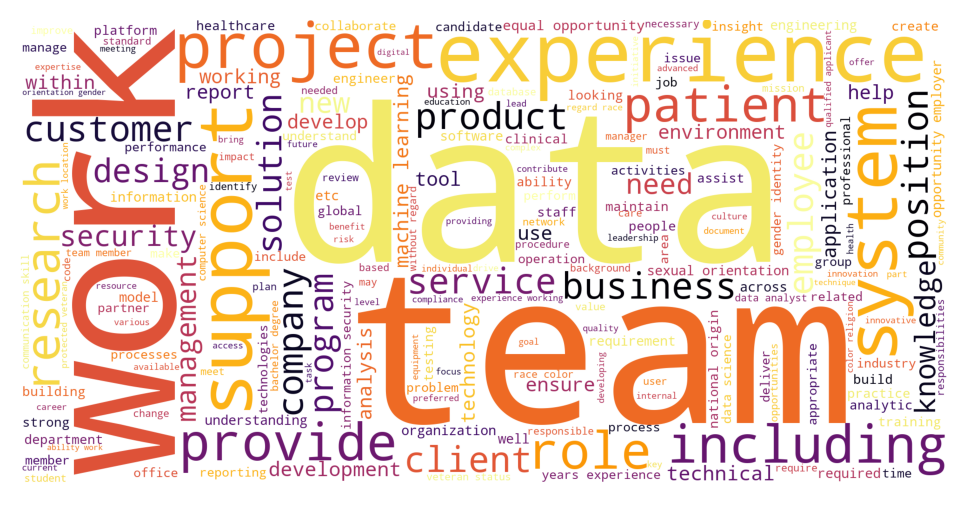

In [14]:
# create wordcloud of most common words in job descriptions
make_wordcloud(job_data, 'inferno')

In [15]:
def barplot(df,industry,location):
    ''' plot a bar graph of top keywords
    
    Args:
        df (dataframe): the dataframe of top keyword
    '''
    
    sns.set(rc={'figure.figsize':(13,8)})
    g = sns.barplot(x="Keyword", y="Frequency", data=df, palette="Blues_d")
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    plt.title(f'Keyword frequency distribution of {industry} job descriptions in {location}')

In [16]:
def get_top_n_words(token, n=20):
    ''' get the top words from a job description in df
    
    Args:
        token (list): filtered list of all keywords from text
        n(int): specifies how many words the user want to see
        
    Returns: top_df (dataframe): datagrame of the top words
    '''
    
    # get the top key words 
    vec = CountVectorizer().fit(token)
    bag_of_words = vec.transform(token)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
        
    # convert most freq words to dataframe for plotting bar plot
    top_df = pd.DataFrame(words_freq[:n])
    top_df.columns=["Keyword", "Frequency"]
    
    return top_df

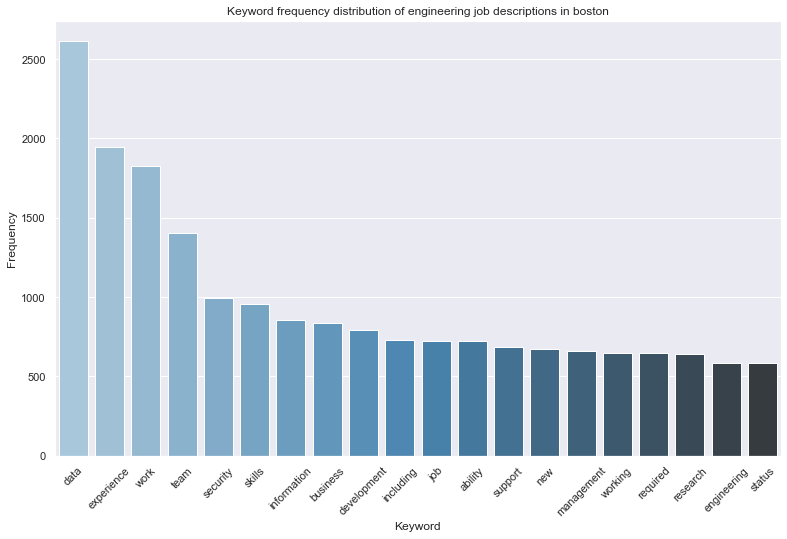

In [17]:
# create list of all keywords provided in a given search query
wordpool = []
for row in job_data['Description']:
    tokens = tokenize(row)
    for word in tokens:
        wordpool.append(word)

# plotting keyword frequency for one industry
top_df = get_top_n_words(wordpool, n=20)
barplot(top_df,'engineering','boston')

## Method

Our assumption is that job descriptions for a given industry search all share a certain subset of keywords/skills that hiring softwares are screening for when applicants submit resumes. This also leads to the assumption that different jobs from various industries also have similarities in desired skills. Using machine learning, we worked to understand what keywords and skills candidates should utilize on their resumes, as well as the overlap of skills that exists between all jobs and job descriptions. 
 
Before applying machine learning tools, we collected relevant industry skills using the ESMI API Open Skills Classification. Since we did not possess domain knowledge of the skills needed across all industries that we were examining, the API allowed us to produce skill lists for a given industry using job descriptions from each specific search query. 
 
Of the skills that we defined as industry-specific from the API, we proceeded to use one-hot-encoding to add each skill to our dataframe and check against each existing job description to determine if that skill was mentioned. This left us with the data needed to predict jobs and understand similarities between jobs using machine learning. 

### Skills Extraction
<a id='extraction'></a>

In [18]:
def get_all_descriptions(job_data):
    ''' extract and clean all description strings from job_data dataframe
    
    Args:
        job_data (df): dataframe of search query, position, company, and description
                       for each job listing 
    
    Returns:
        all_descriptions (dictionary): dictionary where each key is a given search
                       query (corresponding to a given industry) and each key is a 
                       list of all description strings for jobs pertaining to that
                       query.
    '''
    all_descriptions = {}
    
    # loop through all rows of dataframe
    for i in range(len(job_data)):
        row = job_data.iloc[i]
        
        # extract and clean description string
        description = row['Description']
        description = ' '.join([line.strip() for line in description.split('\n') if len(line.strip()) > 1])
        description = description.lower()
        description = re.sub(r'[^A-Za-z0-9 ]+', '', description)
        
        # format dictionary and add row data
        search_key = row['Search']
        all_descriptions[search_key] = all_descriptions.get(search_key, [])
        all_descriptions[search_key].append(description)
        
    return all_descriptions

In [19]:
all_descriptions = get_all_descriptions(job_data)

In [20]:
# Initialize EMSI API
auth_endpoint = "https://auth.emsicloud.com/connect/token" 

# API Key info
client_id = 'w63p8u8ajr44pfbm'
client_secret = 'fghOw08Y' 
scope = "emsi_open" 

# structure API query and return request
payload = "client_id=" + client_id + "&client_secret=" + client_secret + "&grant_type=client_credentials&scope=" + scope 
headers = {'content-type': 'application/x-www-form-urlencoded'}
access_token = json.loads((requests.request("POST", auth_endpoint, data=payload, headers=headers)).text)['access_token']

In [21]:
def extract_skills_from_document(text):
    ''' query EMSI API to extract skills from string
    
    Args: text(string): cleaned job description from Indeed
         
    
    Returns: skills_in_doc_df (pd.DataFrame): skills dataframe from EMSI API
    '''
    
    skills_from_doc_endpoint = "https://emsiservices.com/skills/versions/latest/extract"
    
    # structure the payload with the given string
    payload = f'\"text\": \"... {text} ...\", \"confidenceThreshold\": 0.6'
    payload = "{ " + payload + " }"
        
    headers = {
        'authorization': "Bearer " + access_token,
        'content-type': "application/json"
        }
    
    # request the api
    response = requests.request("POST", skills_from_doc_endpoint, data=payload.encode('utf-8'), headers=headers)
    
    # extract data from json and convert to dataframe
    skills_in_doc_df = pd.DataFrame(json_normalize(response.json()['data'])); 
                                            
    return skills_in_doc_df

In [22]:
def split_for_request(string, n=20000):
    ''' splits string into n-character blocks
    
    Args: string(str): input string
         
    
    Returns: split_strings(list): list of strings
    '''
    
    # define positioning variable and empty list
    shift = 0
    split_strings = []
    
    # iterate through string by n
    for start in range(0, len(string), n):
        
        # internal memory of index
        start += shift
        
        # end if out of range
        if start + n >= len(string):
            end = len(string)
        
        # find nearest break and split
        else:
            end = start + n 
            
            # locate sentence break 
            while string[end] != ' ':
                end += 1
                shift += 1

        # append block to list of strings
        block = string[start:end]
        split_strings.append(block)
        
    return split_strings

In [23]:
def extract_specific_skills(query):
    ''' Call EMSI API and creates txt file of skills
    
    Args: query(str): query to Indeed (job industry)
         
    
    Returns: split_strings(list): list of strings
    '''
    document = ' '.join(all_descriptions[query])
    request_strings = split_for_request(document)
    
    skills_list = []
    
    for i in range(0, len(request_strings)):
        skills_list.append((extract_skills_from_document(request_strings[i])['skill.name']).tolist())
        time.sleep(0.5)
        
    # flatten list of lists made by loop above 
    skills_list = [item for sublist in skills_list for item in sublist]
    
    # remove redundant/repeated skills 
    skills_list = [i for n, i in enumerate(skills_list) if i not in skills_list[:n]]
    
    # save skills as text file
    file = open(f'{query}_skills.txt', 'w')
    for skill in skills_list:
        file.write(skill + "\n")
    file.close()

    return skills_list

In [24]:
# open the text file and read industry skills into a list
skills  = open("skill_list.txt", "r")

industry_skills_list = skills.read()
industry_skills_list = [skill.lower() for skill in industry_skills_list.split('\n')]
industry_skills_list[1:20]

['3d modeling',
 '3d printing',
 '3gpp (telecommunication)',
 'api design',
 'api gateway',
 'awk (programming language)',
 'aws codebuild',
 'aws codepipeline',
 'aws identity and access management (iam)',
 'aws kinesis',
 'aws lambda',
 'aws sagemaker',
 'aws serverless',
 'ability to meet deadlines',
 'abstractions',
 'academic advising',
 'academic papers',
 'acceptance test-driven development',
 'access control list']

In [25]:
def add_skills_cols(df, skills):
    ''' add columns for each skill in each industry
        
    Args:
        df (pd.DataFrame): job dataframe
        skills (list): list of skills from each industry
        
    Return:
        df (pd.DataFrame): updated dataframe with skill columns
        '''
    
    # add skill columns
    for skill in skills:
        col = pd.DataFrame({skill: list(df['Description'].apply(lambda row: int(skill in row)))})
        
        # don't add redundant columns
        if list(col[skill].unique()) != [False] or list(col[skill].unique()) != [True]:
            df = pd.concat([df, col], axis=1)
    
    return df

In [26]:
# add skill columns to df
job_data = add_skills_cols(job_data, industry_skills_list)
job_data.sample(n=10)

Search                                          Position  \
184      data analyst                             Data Analyst Pharmacy   
365  machine learning                         Machine Learning Engineer   
590        healthcare                            Crisis Line Specialist   
283     web developer                          UI/UX Frontend Developer   
32     cyber security     Part-Time Lecturer Online MS in Cybersecurity   
34     cyber security                                Cyber Risk Analyst   
569        healthcare                          Pulmonary Technologist I   
475       engineering  Summer Camp STEM Instructor (full-time seasonal)   
148      data science                         Economic Research Analyst   
347  machine learning                         Machine Learning Engineer   

                                     Company  \
184                    Boston Medical Center   
365             Dana-Farber Cancer Institute   
590  Family Services of the Merrimack Valley   
283                                DataRobot   
32                   Northeastern University   
34                        McKinsey & Company   
569               Boston Children's Hospital   
475                            Empow Studios   
148                               S&P Global   
347               Commonwealth Care Alliance   

                                           Description  .net framework  \
184  position summary:boston medical center health ...               0   
365      job id:        26622       location:      ...               0   
590  430 north canal street lawrence, ma 01840 p: 9...               0   
283     “engprod is the new devops”. we are pioneer...               0   
32      about the opportunity      the khoury colle...               0   
34   who you'll work withyou will be based in our b...               0   
569       61377br         ambulatory services    jo...               0   
475  summer camp stem instructor (full-time seasona...               0   
148  associates in the industry services consulting...               0   
347  build scalable and robust data model/infrastru...               0   

     3d modeling  3d printing  3gpp (telecommunication)  api design  \
184            0            0                         0           0   
365            0            0                         0           0   
590            0            0                         0           0   
283            0            0                         0           0   
32             0            0                         0           0   
34             0            0                         0           0   
569            0            0                         0           0   
475            0            0                         0           0   
148            0            0                         0           0   
347            0            0                         0           0   

     api gateway  ...  writing  written communication  written english  xunit  \
184            0  ...        0                      0                0      0   
365            0  ...        0                      1                0      0   
590            0  ...        0                      0                0      0   
283            0  ...        0                      0                0      0   
32             0  ...        0                      0                0      0   
34             0  ...        1                      0                0      0   
569            0  ...        1                      0                0      0   
475            0  ...        0                      0                0      0   
148            0  ...        1                      0                0      0   
347            0  ...        0                      1                0      0   

     yoga  zbrush  zendesk  zettabyte file system (zfs)  \
184     0       0        0                            0   
365     0       0        0                           

### Machine Learning

Our chosen machine learning tools were K Nearest Neighbors (KNN) and Principal Component Analysis (PCA).

### Nearest Neighbors for Job Recommendation
<a id='recommend'></a>

KNN was chosen as we wanted to be able to determine the most relevant jobs for a candidate based on the current skills in their resume. KNN is a versatile algorithm that classifies a data point based on how its neighbor is classified. Using the skills extracted from the candidate's resume, we can match those sets of skills to the skills from jobs in our data to recommend the top 10 jobs their resume is best suited for.

In [27]:
def read_resume(filename, skills, label):
    ''' read .txt file resume into a string
    
    Args:
        filename (str): filename of resume
        
    Return:
        resume (str)
    '''
    # read .txt file into string and put in lowercase
    resume = Path(filename).read_text().lower()
    
    # remove new line characters
    resume = re.sub('\n',' ', resume)
    
    # create df row with skills cols similar to job dataframe
    applicant_df = add_skills_cols(pd.DataFrame({'Search': [label],
                                                 'Position': ['student'],
                                                 'Company': ['Northeastern University'],
                                                 'Description': [resume]}), skills)
    
    return applicant_df

In [28]:
# load all applicant resumes
ananda = read_resume('ananda_res.txt', industry_skills_list, 'ananda')
ethan = read_resume('resume_ethan.txt', industry_skills_list, 'ethan')
keegan = read_resume('keegan_resume.txt', industry_skills_list, 'keegan')
erika = read_resume('Erika_ackley_resume.txt', industry_skills_list, 'erika')
khoa = read_resume('KhoaVo_Resume.txt', industry_skills_list, 'khoa')

In [29]:
def find_best_jobs(df, applicant_row, k):
    '''output job recommendations based on user's resume
        
    Args:
        df (pd.DataFrame): dataframe that contains web_scraped job data
        applicant_row (pd.DataFrame): single column dataframe with applicant's resume and skills
        k (int): number of jobs to recommend for user
        
    Return:
        job_recs (pd.DataFrame): dataframe with k jobs most closely similiar to applicant's resume
        
    '''
    # get skill cols
    skill_cols = list(set(df.columns).difference(['Search', 'Description', 'Company', 'Position']))
    
    # update dfs
    skills_df = df.loc[:, skill_cols]
    applicant_skills = applicant_row.loc[:, skill_cols]
    
    # find k jobs most similiar to applicant's resume
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(skills_df)
    neighbor_indexes = list(neigh.kneighbors(applicant_skills, return_distance=False)[0])
    job_recs = df[df.index.isin(neighbor_indexes)].loc[:, ['Search', 'Company', 'Position', 'Description']]
        
    return job_recs

In [30]:
# set k value
k = 10

# get all applicants
applicants = {'ananda': ananda,
              'ethan': ethan,
              'erika': erika,
              'keegan': keegan,
              'khoa': khoa
             }

# use ML to recommend jobs for applicant based on resume
for applicant in applicants.keys():
    print(f'top {k} jobs for {applicant}:')
    resume = applicants[applicant]
    display(find_best_jobs(job_data, resume, k))

top 10 jobs for ananda:


Search                            Company  \
32     cyber security            Northeastern University   
91       data science                             Rapid7   
92       data science            Northeastern University   
93       data science      US Bureau of Labor Statistics   
103      data science       Chen Lab @ Boston University   
120      data science                             Jebbit   
153      data science                           CarGurus   
157      data science  US Veterans Health Administration   
203      data analyst                             Jebbit   
404  machine learning                             Rapid7   

                                              Position  \
32       Part-Time Lecturer Online MS in Cybersecurity   
91                                  Data Science Co-Op   
92                                 Lead Data Scientist   
93    Supervisory Economist / Statistician (Economics)   
103                                     Data Scientist   
120                                       Data Analyst   
153                          Data Science Data Analyst   
157  Program Analyst - Statistical Analysis System ...   
203                                       Data Analyst   
404                                 Data Science Co-Op   

                                           Description  
32      about the opportunity      the khoury colle...  
91   rapid7 is looking for a curious, resourceful a...  
92      about the opportunity      northeastern uni...  
93     help   this job is open tocareer transition ...  
103                                     data scientist  
120  we are looking for an inquisitive, experienced...  
153  meet cargurus—the #1 visited online car shoppi...  
157    help   this job is open tothe publicu.s. cit...  
203  we are looking for an inquisitive, experienced...  
404  rapid7 is looking for a curious, resourceful a...

top 10 jobs for ethan:


Search                            Company  \
32     cyber security            Northeastern University   
91       data science                             Rapid7   
157      data science  US Veterans Health Administration   
202      data analyst                       Primark - US   
260     web developer                           Revature   
343  machine learning      US Bureau of Labor Statistics   
377  machine learning          Flagship Pioneering, Inc.   
404  machine learning                             Rapid7   
426       engineering                             Leidos   
587        healthcare                       Trader Joe's   

                                              Position  \
32       Part-Time Lecturer Online MS in Cybersecurity   
91                                  Data Science Co-Op   
157  Program Analyst - Statistical Analysis System ...   
202                         Customs Compliance Analyst   
260                  Front End Developer (Entry level)   
343   Supervisory Economist / Statistician (Economics)   
377  Co-op, Preclinical Discovery and Development (...   
404                                 Data Science Co-Op   
426       Distribution Construction Standards Engineer   
587         Nutrition & Regulatory Labeling Specialist   

                                           Description  
32      about the opportunity      the khoury colle...  
91   rapid7 is looking for a curious, resourceful a...  
157    help   this job is open tothe publicu.s. cit...  
202  objective:the junior customs specialist/admin ...  
260  one day someone is going to ask you where you ...  
343    help   this job is open tocareer transition ...  
377  position: co-op, preclinical discovery and dev...  
404  rapid7 is looking for a curious, resourceful a...  
426  description job description: pay range: pay ra...  
587  who are we?trader joe's is your favorite neigh...

top 10 jobs for erika:


Search                            Company  \
1      cyber security                           Revature   
32     cyber security            Northeastern University   
93       data science      US Bureau of Labor Statistics   
103      data science       Chen Lab @ Boston University   
157      data science  US Veterans Health Administration   
175      data analyst                            Digitas   
240      data analyst                      Aura Sub, LLC   
260     web developer                           Revature   
343  machine learning      US Bureau of Labor Statistics   
426       engineering                             Leidos   

                                              Position  \
1                             Junior Security Engineer   
32       Part-Time Lecturer Online MS in Cybersecurity   
93    Supervisory Economist / Statistician (Economics)   
103                                     Data Scientist   
157  Program Analyst - Statistical Analysis System ...   
175                         Analyst, Data and Analysis   
240                  Data Analyst - Customer Obsession   
260                  Front End Developer (Entry level)   
343   Supervisory Economist / Statistician (Economics)   
426       Distribution Construction Standards Engineer   

                                           Description  
1    we are seeking talented individuals that are m...  
32      about the opportunity      the khoury colle...  
93     help   this job is open tocareer transition ...  
103                                     data scientist  
157    help   this job is open tothe publicu.s. cit...  
175   analyst, data & analysis intern (virtual)  we...  
240  aura is on a mission to create a safer interne...  
260  one day someone is going to ask you where you ...  
343    help   this job is open tocareer transition ...  
426  description job description: pay range: pay ra...

top 10 jobs for keegan:


Search                            Company  \
93       data science      US Bureau of Labor Statistics   
103      data science       Chen Lab @ Boston University   
157      data science  US Veterans Health Administration   
260     web developer                           Revature   
343  machine learning      US Bureau of Labor Statistics   
426       engineering                             Leidos   
505        healthcare        Green Valley Medical Clinic   
506        healthcare           Neponset Animal Hospital   
519        healthcare  US Veterans Health Administration   
570        healthcare          Deluxe family dental care   

                                              Position  \
93    Supervisory Economist / Statistician (Economics)   
103                                     Data Scientist   
157  Program Analyst - Statistical Analysis System ...   
260                  Front End Developer (Entry level)   
343   Supervisory Economist / Statistician (Economics)   
426       Distribution Construction Standards Engineer   
505                            Patient Care Technician   
506                                   Kennel Attendant   
519                                      Social Worker   
570                            Front Desk Receptionist   

                                           Description  
93     help   this job is open tocareer transition ...  
103                                     data scientist  
157    help   this job is open tothe publicu.s. cit...  
260  one day someone is going to ask you where you ...  
343    help   this job is open tocareer transition ...  
426  description job description: pay range: pay ra...  
505  green valley medical clinic is breaking new gr...  
506  we are looking to hire a kennel attendant at o...  
519    help   this job is open tothe publicu.s. cit...  
570  experience with eaglesoft dental software.duti...

top 10 jobs for khoa:


Search                            Company  \
1      cyber security                           Revature   
32     cyber security            Northeastern University   
93       data science      US Bureau of Labor Statistics   
103      data science       Chen Lab @ Boston University   
153      data science                           CarGurus   
157      data science  US Veterans Health Administration   
240      data analyst                      Aura Sub, LLC   
260     web developer                           Revature   
343  machine learning      US Bureau of Labor Statistics   
426       engineering                             Leidos   

                                              Position  \
1                             Junior Security Engineer   
32       Part-Time Lecturer Online MS in Cybersecurity   
93    Supervisory Economist / Statistician (Economics)   
103                                     Data Scientist   
153                          Data Science Data Analyst   
157  Program Analyst - Statistical Analysis System ...   
240                  Data Analyst - Customer Obsession   
260                  Front End Developer (Entry level)   
343   Supervisory Economist / Statistician (Economics)   
426       Distribution Construction Standards Engineer   

                                           Description  
1    we are seeking talented individuals that are m...  
32      about the opportunity      the khoury colle...  
93     help   this job is open tocareer transition ...  
103                                     data scientist  
153  meet cargurus—the #1 visited online car shoppi...  
157    help   this job is open tothe publicu.s. cit...  
240  aura is on a mission to create a safer interne...  
260  one day someone is going to ask you where you ...  
343    help   this job is open tocareer transition ...  
426  description job description: pay range: pay ra...

### Results

Our group’s resumes were used above to produce the top 10 best job recommendations using KNN. It is important to note that we are all students with large technical skillsets, thus explaining the similarity in industries and some of the jobs recommended to us.

### PCA
<a id='comparison'></a>

PCA was chosen as we needed to reduce the dimensions of our skills data, while retaining trends and patterns, in order to understand the overlap of skills desired between jobs and industries. Since PCA is an unsupervised technique primarily for interpreting data, information loss is a necessary component. We chose to analyze PCA features 0 and 1 as they contained the most amount of information according to the explained variances below. 

In [31]:
# merge job & applicant df
app_n_job_df = pd.concat([job_data, ananda, erika, keegan, khoa, ethan]).reset_index(drop=True)

# apply one hot encoding to each skill
enc = OneHotEncoder()
X = enc.fit_transform(app_n_job_df).toarray()

In [32]:
# create column for size of dots in visualization (making applicant dots bigger)
app_n_job_df['size'] = .2
for i in range(594, 599):
    app_n_job_df.loc[i, 'size'] = 4

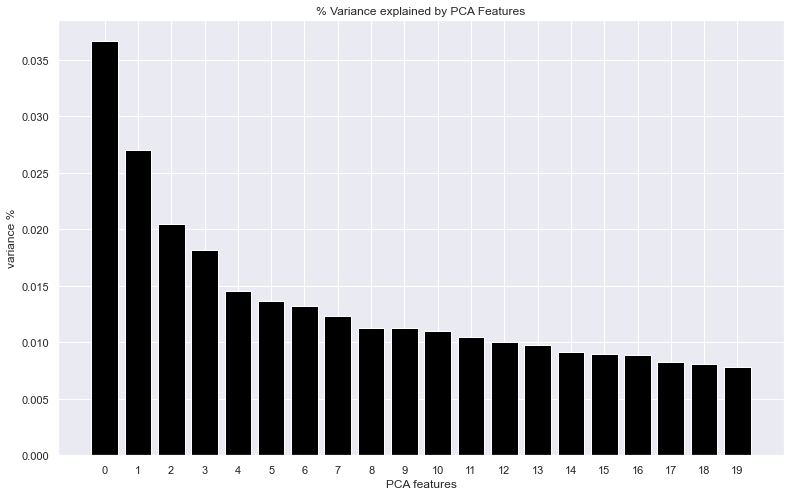

In [33]:
# create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X)

# plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.title('% Variance explained by PCA Features')
plt.xticks(features)

# save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [34]:
# pca with optimal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [35]:
# visualize pca
app_n_job_df['pca0'] = X_pca[:, 0]
app_n_job_df['pca1'] = X_pca[:, 1]

hover_data = ['Position','Company']
px.scatter(app_n_job_df, x='pca0',y='pca1',hover_data=hover_data, color='Search',
           title='Similarities Among Descriptions based on Industries', size='size')

### Results

As seen above, we were able to create an interactive PCA plot to show clusters of jobs based on their similarities. Each data point represents a job and they are all colored according to the industry they belong to. The large, opaque circles represent where we are group members fall according to the clustering of jobs and show nearby jobs that our resumes align with. 

## Discussion

Based on the outputs we were able to produce, both using KNN and PCA, our group considers this project to be promising start to fighting machine-based hiring softwares, but not robust enough for implementation as of yet. The framework we built is able to identify the n-closest jobs from a resume based on how much overlap there is between the resume skills and the skills of jobs in our data. The jobs recommended to our group members above are well aligned with the skills we have identified on our resumes, and there seems to be a strong overlap of skills in a few of the industries such as machine learning, data science, data analyst. This is further supported with our PCA plot which shows strong similarity between machine learning and data science (red and organge dots) as well as with cybersecurity and engineering (purple and blue dots). 

To improve recommendations we would look to training the model using data on resumes of candidates who did apply and successfully get interviews for certain jobs. Furthermore, our project does rely on the assumption that the hiring softwares used are specifically looking at just the skills on a resume that pass through them. This means that it does not consider education or certain positions held previously by the candidate when recommending jobs and these are factors that hiring softwares could be using. Additionally we are unable to account for position type, where recommendations could be anywhere from entry level to senior director.

### Takeaway

All together we feel that we have made good progress on exploring job data and understanding the overlap in skill expectations for cadidates, thus strengthening the knowledge needed to get resumes past hiring softwares. To be implemented and used as a tool, further developments and data are required. 